In [1]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [31]:
import importlib
import feature_25  # or whatever your module name is
importlib.reload(feature_25)


<module 'feature_25' from 'c:\\Users\\victo\\0_thesis_repo\\thesis_vri_vp\\victor\\feature_25.py'>

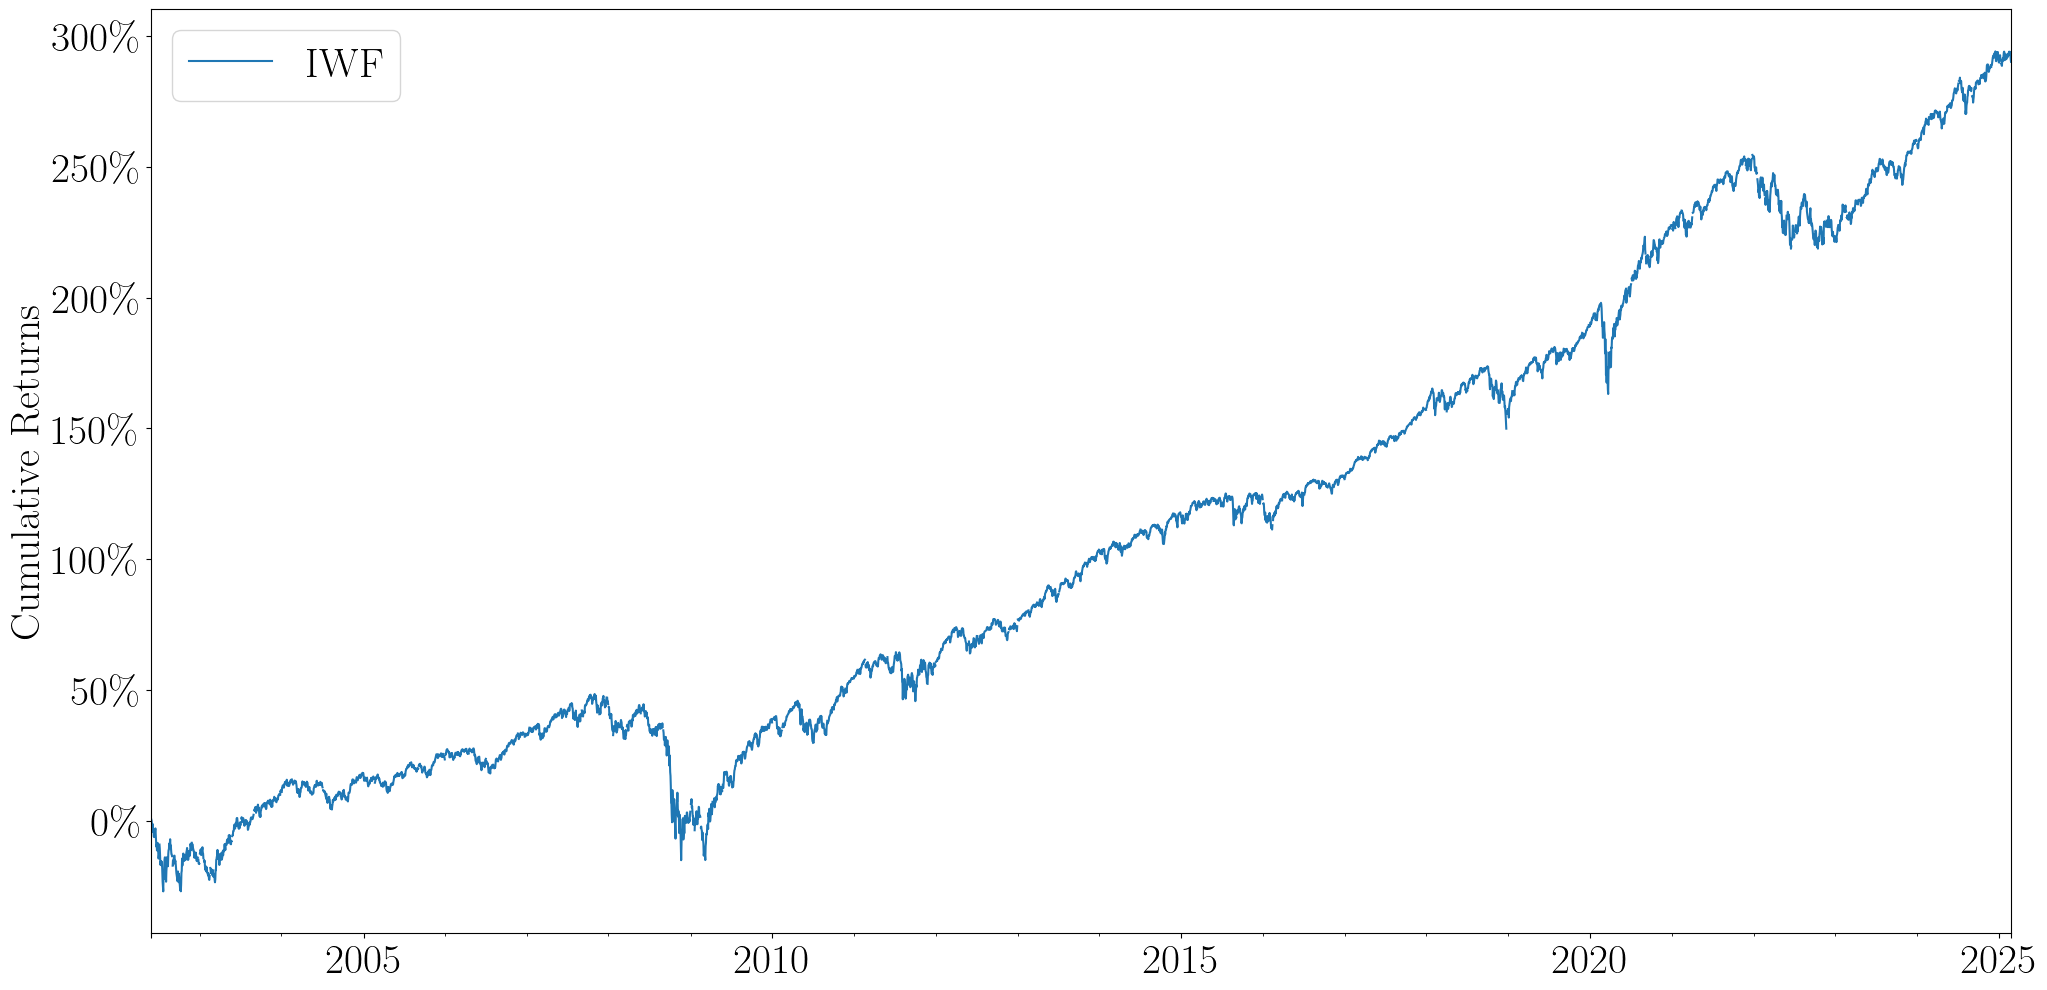

In [ ]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

# Use DataLoader to generate features when we use factor and market data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    ver="v2",
    factor_col="IWF"  # specify which column in factor_data.csv is your factor return
).load(start_date="2002-05-31", end_date="2025-02-24")

# print("Daily returns:", data.ret_ser)
# print("Engineered features:", data.X)

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

# Plot cumulative returns
# plot_cumret(factor_data["IWF"])
# plt.show()


In [3]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01" #actual start date of training will be in August due to 63 trading days required for EWMA
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-08-28 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [10]:
def rolling_window_cv_sjm_long_short(
    lam, kappa, 
    X, 
    factor_returns, 
    market_returns, 
    n_splits=5, 
    min_train_size=5*252,
    cost_per_100pct=0.0005,  # 5 bps cost per 100% turnover
    annual_threshold=0.05    # ±5% annual threshold
):
    """
    Perform rolling expanding-window cross-validation using a
    long–short strategy evaluation as described in Shu et al. (2025).

    Parameters
    ----------
    lam : float
        The jump penalty parameter (lambda).
    kappa : float
        The sqrt of max features (kappa). The model will use int(kappa^2) features.
    X : pd.DataFrame
        Feature matrix (indexed by date).
    factor_returns : pd.Series
        Daily returns for the factor (indexed by date).
    market_returns : pd.Series
        Daily returns for the corresponding market or benchmark (indexed by date).
    n_splits : int, optional
        Number of cross-validation folds (default is 5).
    min_train_size : int, optional
        Minimum number of samples in the training set (default is ~5 years).
    cost_per_100pct : float, optional
        Transaction cost for a 100% position turnover (default is 5 bps).
    annual_threshold : float, optional
        Threshold (±5%) in annualized expected returns for deciding full long/short.

    Returns
    -------
    float
        The average Sharpe ratio across all cross-validation folds
        for the hypothetical long–short strategy.
    """
    # Compute the split size for rolling expanding-window cross-validation
    split_size = (len(X) - min_train_size) // n_splits

    # Compute the number of maximum features based on kappa
    max_feats = int(kappa**2)

    # List to store Sharpe ratios for each validation fold
    sharpe_scores = []

    # Helper function to determine position based on expected annualized return
    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        """
        Maps the expected annualized active return to a position in [-1, 1].
        If ann_ret > threshold, fully long = +1.
        If ann_ret < -threshold, fully short = -1.
        Else linearly scale between -1 and +1.
        """
        if ann_ret > threshold:
            return 1.0
        elif ann_ret < -threshold:
            return -1.0
        else:
            return ann_ret / threshold  # Scale linearly between -1 and +1

    # Loop over cross-validation splits
    for i in range(n_splits):
        # Define training and validation split
        train_end = min_train_size + i * split_size
        X_train_cv = X.iloc[:train_end]  # # selects the first train_end rows from X and y, creating a training dataset.
        X_val_cv   = X.iloc[train_end:]  # selectes the rows after train_end and forward to be used for out of sample validation

        y_train_cv = factor_returns.iloc[:train_end]  # Training factor returns
        y_val_cv   = factor_returns.iloc[train_end:]  # Validation factor returns

        m_train_cv = market_returns.iloc[:train_end]  # Training market returns
        m_val_cv   = market_returns.iloc[train_end:]  # Validation market returns

        # Fit Sparse Jump Model (SJM) on training data
        model = SparseJumpModel(
            n_components=2,  # Model assumes two regimes
            max_feats=max_feats,  # Limit number of features
            jump_penalty=lam,  # Regularization parameter for jumps
            cont=False,  # Discrete jump model
            max_iter=10  # Maximum iterations for fitting
        )
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")  # Fit model using cumulative returns as sorting criterion

        # Get in-sample regime predictions for training data
        train_states = model.predict(X_train_cv)

        # Compute daily active returns in training set (factor return minus market return)
        train_active_ret = y_train_cv - m_train_cv

        # Compute expected annualized return for each state
        unique_states = np.unique(train_states)
        state_to_expected = {}
        for st in unique_states:
            mask_st = (train_states == st)  # Identify samples in the state
            if mask_st.sum() > 0:
                avg_daily = train_active_ret[mask_st].mean()  # Average daily return for the state
                ann_ret = avg_daily * 252.0  # Annualized return
            else:
                ann_ret = 0.0  # Default to zero if state is empty
            state_to_expected[st] = ann_ret  # Store expected return for state

        # Predict states in validation set
        val_states = model.predict(X_val_cv)

        # Compute strategy performance in validation set
        val_active_ret = y_val_cv - m_val_cv  # Compute active return in validation
        val_positions = np.zeros(len(val_states))  # Store factor exposure in [-1, 1]
        strategy_ret = np.zeros(len(val_states))  # Track daily returns (net of costs)

        prev_position = 0.0  # Initialize previous position for turnover calculation

        for t in range(len(val_states)):
            st = val_states[t]  # Get predicted state for the day
            exp_ann_ret = state_to_expected.get(st, 0.0)  # Get expected return for state
            position = position_from_expected_return(exp_ann_ret, annual_threshold)  # Determine position

            # Compute daily turnover cost
            turnover = abs(position - prev_position) * 2.0  # Turnover is doubled for long/short trades
            cost = turnover * cost_per_100pct  # Multiply by cost per 100% turnover

            # Compute daily profit and loss (PnL) net of transaction cost
            daily_pnl = position * val_active_ret.iloc[t]  # Daily PnL from active return
            daily_net = daily_pnl - cost  # Subtract transaction costs

            strategy_ret[t] = daily_net  # Store net return
            prev_position = position  # Update previous position

        # Compute Sharpe ratio for the validation period
        avg_ret = np.mean(strategy_ret)  # Mean daily return
        std_ret = np.std(strategy_ret, ddof=1)  # Standard deviation of daily returns
        if std_ret == 0:
            val_sharpe = 0.0  # Avoid division by zero
        else:
            val_sharpe = (avg_ret / std_ret) * np.sqrt(252.0)  # Annualized Sharpe ratio

        sharpe_scores.append(val_sharpe)  # Store Sharpe ratio for this fold

    return np.mean(sharpe_scores)  # Return average Sharpe ratio across folds

# Example usage in parallel cross-validation:
lambda_values = np.logspace(0.5, 2, 5)  # Generate λ values from 1 to 100
kappa_values  = np.linspace(1, np.sqrt(X_train_processed.shape[1]), 5)  # Generate κ values

# Assign market return series
market_ser = data.market_ser  # Ensure market returns are aligned with factor returns

# Perform cross-validation in parallel using joblib
results = Parallel(n_jobs=4)(
    delayed(rolling_window_cv_sjm_long_short)(
        lam, kappa, 
        X_train_processed, 
        factor_returns=data.ret_ser, 
        market_returns=market_ser
    )
    for lam in lambda_values  # Iterate over lambda values
    for kappa in kappa_values  # Iterate over kappa values
)

# Identify the best lambda and kappa combination
best_index = np.argmax(results)  # Find index of max Sharpe ratio
best_lambda = lambda_values[best_index // len(kappa_values)]  # Extract corresponding lambda
best_kappa = kappa_values[best_index % len(kappa_values)]  # Extract corresponding kappa
max_feats_best = int(best_kappa**2)  # Compute best max features

# Print optimal hyperparameters
print(f"Best Jump Penalty (λ): {best_lambda}")
print(f"Best Max Features (κ²): {max_feats_best}")


Best Jump Penalty (λ): 3.1622776601683795
Best Max Features (κ²): 11


In [9]:
print(best_index)
print(results[3])

3
0.22306300988192795


[Text(0.5, 1.0, 'Best SJM ($\\lambda$=1.0, $\\kappa^2$=11)')]

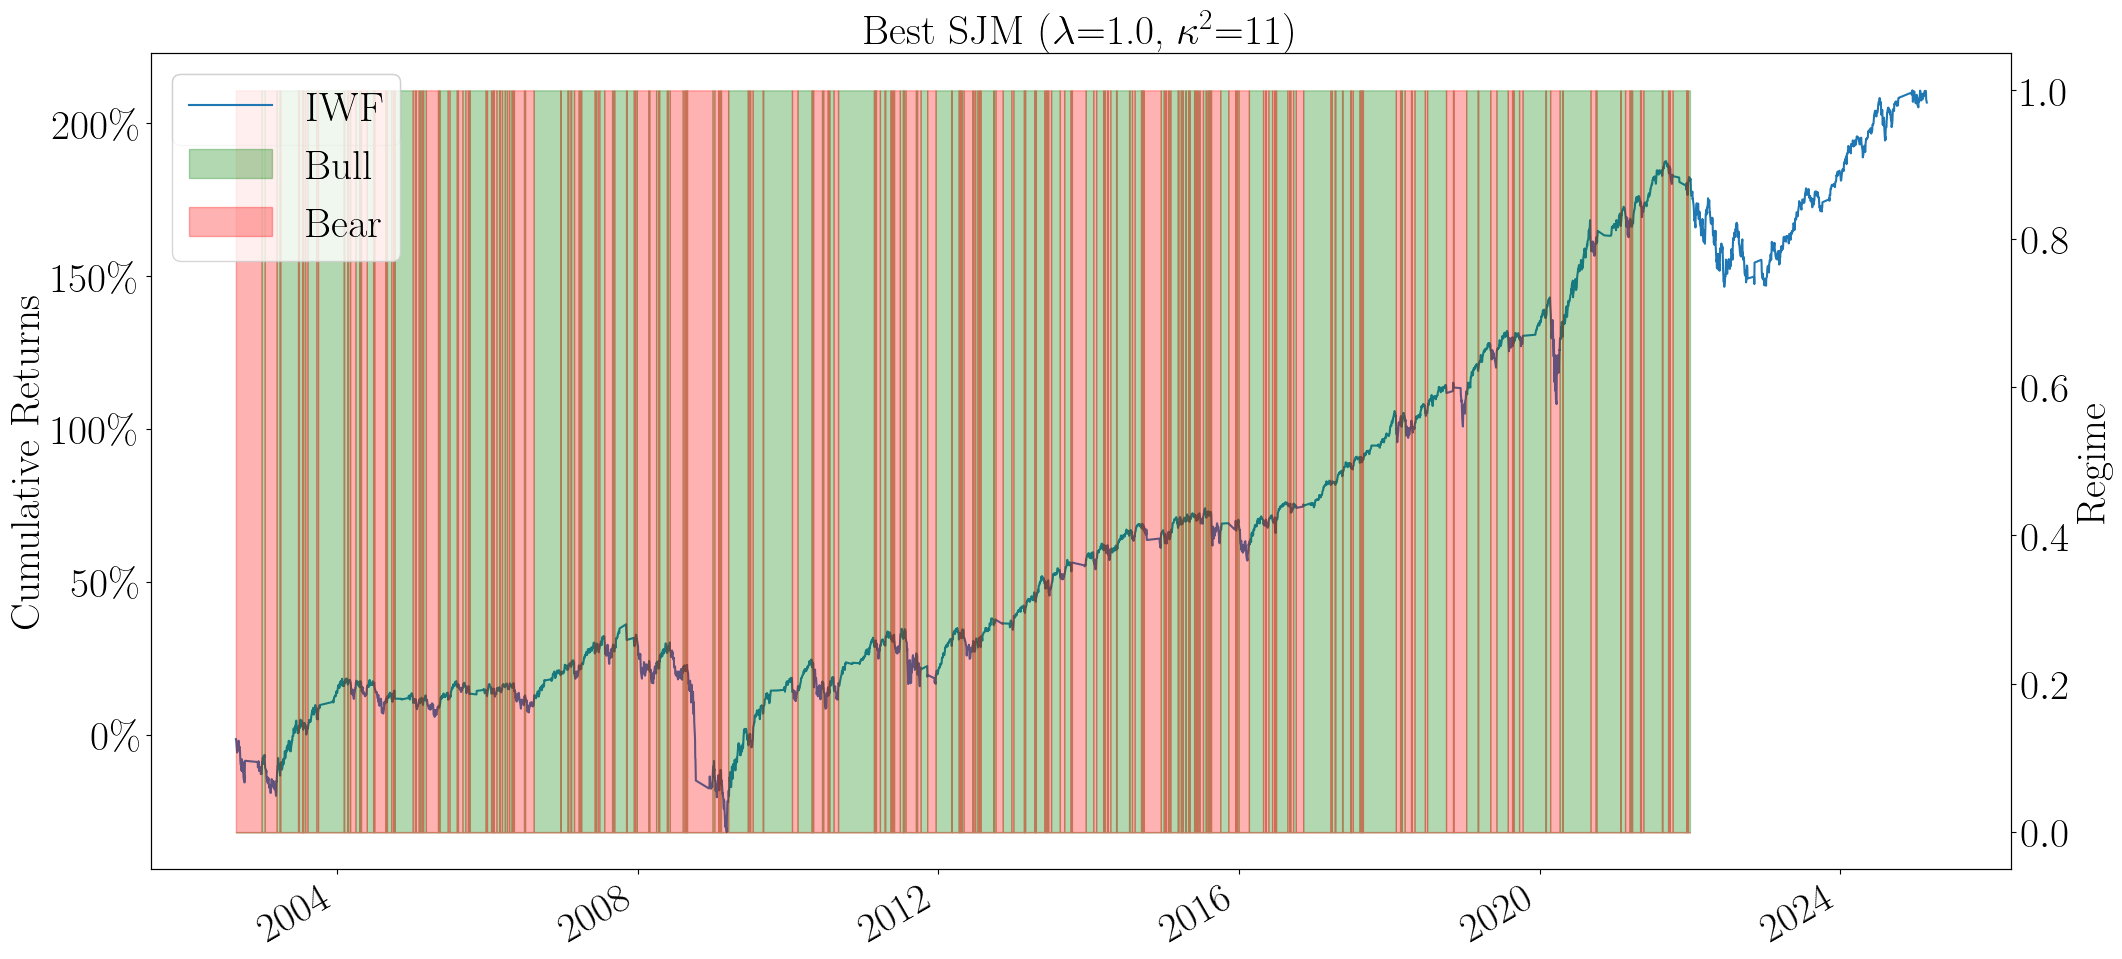

In [5]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=max_feats_best, jump_penalty=best_lambda, cont=False, max_iter=10)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")

# **Predict and Plot Results**
predicted_states = best_model.predict(X_train_processed)
ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
#plt.show()


In [6]:
# Predict the states on the in-sample data
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(best_model.feat_weights)

Predicted states (in-sample):
Date
2002-08-28    1
2002-08-29    1
2002-08-30    1
2002-09-03    1
2002-09-04    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 4076, dtype: int64
SJM Feature Weights:
ActiveReturn_EWMA_8         0.126530
ActiveReturn_EWMA_21        0.117212
ActiveReturn_EWMA_63        0.086707
RSI_8                       0.555947
RSI_21                      0.615561
RSI_63                      0.457917
StochOsc_%K_8               0.517224
StochOsc_%K_21              0.709751
StochOsc_%K_63              0.651034
MACD_8_21                   0.285717
MACD_21_63                  0.131538
DownsideDev_log_21          0.107013
ActiveMarketBeta_EWMA_21    0.033949
MarketReturn_EWMA_21        0.594978
VIX_log_diff_EWMA_21        0.529109
2Y_diff_EWMA_21             0.159112
10Y-2Y_EWMA_21              0.069571
dtype: float64


In [8]:
sum(best_model.feat_weights)

5.7488700610947445

In [2]:
print("\n\n".join(In[i] for i in range(1, len(In))))


print("\n\n".join(In[i] for i in range(1, len(In))))

print("\n\n".join(In[i] for i in range(1, len(In))))


In [10]:
print(results)

[254.01492037151655, 254.01492037151655, 262.26472139168004, 262.26472139168004, 273.956342938112, 273.03025254098714, 268.39446988299494, 273.08818589205276, 278.35351324228463, 283.44502719456807, 248.48520863953794, 248.48520863953794, 259.9828977511637, 259.9828977511637, 265.5045742472751, 255.66666202762676, 258.53326856808144, 264.59523899567023, 265.760572835026, 265.98062171419963, 245.70407749396992, 245.70407749396992, 256.4517329261581, 256.4517329261581, 262.7516806539176, 249.28945922997235, 248.3194035964601, 250.15092410397597, 253.81941759304232, 251.7158712080659, 251.07828371787173, 251.07828371787173, 254.52529853681045, 254.52529853681045, 247.06067251203368, 245.48591701414293, 242.1283981487466, 243.61299893679944, 242.94189859953076, 243.93464177508227, 274.9440568232787, 274.9440568232787, 258.7433349369608, 258.7433349369608, 221.92922017670122, 222.62338715711616, 219.62341784480776, 217.94568827161123, 216.93607900297897, 220.3130352134213, 276.7081702115382